In [1]:
import numpy as np
import time
import psutil
import os
import importlib

In [2]:
# Reload the module to pick up changes
import src.generate_data
importlib.reload(src.generate_data)
from src.generate_data import generate_multiple_datasets

In [3]:
import datasketches
from tdigest import TDigest
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
def benchmark_numpy_quantiles_multiple(datasets, quantiles):
    """
    Benchmark numpy.quantile() across multiple datasets for robust measurement.
    
    Parameters:
    -----------
    datasets : list of np.ndarray
        List of input data arrays
    quantiles : list
        List of quantiles to compute (0.0 to 1.0)
    
    Returns:
    --------
    dict
        Benchmark results with statistics across all runs
    """
    process = psutil.Process(os.getpid())
    computation_times = []
    memory_usages = []
    all_quantile_values = []
    
    for data in datasets:
        # Memory before computation
        mem_before = process.memory_info().rss / 1024 / 1024  # MB
        
        # Time quantile computation
        start_time = time.perf_counter()
        quantile_values = np.quantile(data, quantiles)
        end_time = time.perf_counter()
        
        # Memory after computation
        mem_after = process.memory_info().rss / 1024 / 1024  # MB
        
        computation_times.append(end_time - start_time)
        memory_usages.append(mem_after - mem_before)
        all_quantile_values.append(quantile_values)
    
    # Compute statistics
    times = np.array(computation_times)
    memories = np.array(memory_usages)
    
    return {
        'method': 'numpy_quantile',
        'num_runs': len(datasets),
        'data_size': len(datasets[0]),
        'computation_time_mean': times.mean(),
        'computation_time_std': times.std(),
        'computation_time_min': times.min(),
        'computation_time_max': times.max(),
        'memory_usage_mean': memories.mean(),
        'memory_usage_std': memories.std(),
        'all_quantile_values': all_quantile_values  # Keep all values for comparison
    }

In [5]:
%%time
print("Generating datasets...")
datasets = generate_multiple_datasets(num_datasets=100, size=100_000)
quantiles = np.arange(0.0, 1.1, 0.1)

print(f"Generated {len(datasets)} datasets with {len(datasets[0]):,} samples each")
print(f"Quantiles to compute: {len(quantiles)}")

Generating datasets...
Generated 100 datasets with 100,000 samples each
Quantiles to compute: 11
CPU times: user 8.4 s, sys: 217 ms, total: 8.61 s
Wall time: 8.9 s


In [6]:
%%time
# Benchmark numpy quantiles across all datasets
print("\nRunning baseline benchmark...")
numpy_results = benchmark_numpy_quantiles_multiple(datasets, quantiles)

print(f"\nBaseline (numpy.quantile) Results over {numpy_results['num_runs']} runs:")
print(f"Computation time: {numpy_results['computation_time_mean']*1000:.2f} ± {numpy_results['computation_time_std']*1000:.2f} ms")
print(f"Memory usage: {numpy_results['memory_usage_mean']:.2f} ± {numpy_results['memory_usage_std']:.2f} MB")
print(f"Time range: {numpy_results['computation_time_min']*1000:.2f} - {numpy_results['computation_time_max']*1000:.2f} ms")

print(f"\nQuantile values saved for comparison: {len(numpy_results['all_quantile_values'])} datasets × {len(quantiles)} quantiles")


Running baseline benchmark...

Baseline (numpy.quantile) Results over 100 runs:
Computation time: 2.15 ± 0.22 ms
Memory usage: 0.13 ± 0.32 MB
Time range: 1.93 - 4.10 ms

Quantile values saved for comparison: 100 datasets × 11 quantiles
CPU times: user 210 ms, sys: 5.17 ms, total: 215 ms
Wall time: 216 ms


In [7]:
def benchmark_kll_quantiles_multiple(datasets, quantiles, k=200):
    """
    Benchmark KLL algorithm across multiple datasets.
    
    Parameters:
    -----------
    datasets : list of np.ndarray
        List of input data arrays
    quantiles : list
        List of quantiles to compute (0.0 to 1.0)
    k : int
        KLL sketch parameter (controls accuracy/memory trade-off)
    
    Returns:
    --------
    dict
        Benchmark results with statistics across all runs
    """
    process = psutil.Process(os.getpid())
    construction_times = []
    query_times = []
    memory_usages = []
    all_quantile_values = []
    
    for data in datasets:
        # Memory before construction
        mem_before = process.memory_info().rss / 1024 / 1024  # MB
        
        # Time sketch construction
        start_time = time.perf_counter()
        sketch = datasketches.kll_floats_sketch(k)
        for value in data:
            sketch.update(value)
        construction_end = time.perf_counter()
        
        # Time quantile queries
        quantile_values = []
        for q in quantiles:
            query_start = time.perf_counter()
            quantile_val = sketch.get_quantile(q)
            query_end = time.perf_counter()
            quantile_values.append(quantile_val)
        
        total_end = time.perf_counter()
        
        # Memory after computation
        mem_after = process.memory_info().rss / 1024 / 1024  # MB
        
        construction_times.append(construction_end - start_time)
        query_times.append(total_end - construction_end)
        memory_usages.append(mem_after - mem_before)
        all_quantile_values.append(quantile_values)
    
    # Compute statistics
    construction_times = np.array(construction_times)
    query_times = np.array(query_times)
    total_times = construction_times + query_times
    memories = np.array(memory_usages)
    
    return {
        'method': 'kll',
        'k_parameter': k,
        'num_runs': len(datasets),
        'data_size': len(datasets[0]),
        'construction_time_mean': construction_times.mean(),
        'construction_time_std': construction_times.std(),
        'query_time_mean': query_times.mean(),
        'query_time_std': query_times.std(),
        'total_time_mean': total_times.mean(),
        'total_time_std': total_times.std(),
        'total_time_min': total_times.min(),
        'total_time_max': total_times.max(),
        'memory_usage_mean': memories.mean(),
        'memory_usage_std': memories.std(),
        'all_quantile_values': all_quantile_values
    }

In [8]:
%%time
print("Running KLL benchmark...")
datasets = generate_multiple_datasets(num_datasets=100, size=100_000)
kll_results = benchmark_kll_quantiles_multiple(datasets, quantiles, k=200)

print(f"\nKLL Results over {kll_results['num_runs']} runs (k={kll_results['k_parameter']}):")
print(f"Construction time: {kll_results['construction_time_mean']*1000:.2f} ± {kll_results['construction_time_std']*1000:.2f} ms")
print(f"Query time: {kll_results['query_time_mean']*1000:.2f} ± {kll_results['query_time_std']*1000:.2f} ms")
print(f"Total time: {kll_results['total_time_mean']*1000:.2f} ± {kll_results['total_time_std']*1000:.2f} ms")
print(f"Memory usage: {kll_results['memory_usage_mean']:.2f} ± {kll_results['memory_usage_std']:.2f} MB")
print(f"Time range: {kll_results['total_time_min']*1000:.2f} - {kll_results['total_time_max']*1000:.2f} ms")

Running KLL benchmark...

KLL Results over 100 runs (k=200):
Construction time: 59.37 ± 0.54 ms
Query time: 0.01 ± 0.00 ms
Total time: 59.38 ± 0.54 ms
Memory usage: 0.00 ± 0.02 MB
Time range: 58.36 - 62.55 ms
CPU times: user 7.76 s, sys: 39.3 ms, total: 7.8 s
Wall time: 7.82 s


In [9]:
def benchmark_tdigest_quantiles_multiple(datasets, quantiles, delta=100):
    """
    Benchmark T-Digest algorithm across multiple datasets.
    
    Parameters:
    -----------
    datasets : list of np.ndarray
        List of input data arrays
    quantiles : list
        List of quantiles to compute (0.0 to 1.0)
    delta : int
        T-Digest compression parameter (controls accuracy/memory trade-off)
    
    Returns:
    --------
    dict
        Benchmark results with statistics across all runs
    """
    process = psutil.Process(os.getpid())
    construction_times = []
    query_times = []
    memory_usages = []
    all_quantile_values = []
    
    for data in datasets:
        # Memory before construction
        mem_before = process.memory_info().rss / 1024 / 1024  # MB
        
        # Time digest construction
        start_time = time.perf_counter()
        digest = TDigest(delta=delta)
        for value in data:
            digest.update(value)
        construction_end = time.perf_counter()
        
        # Time quantile queries
        quantile_values = []
        for q in quantiles:
            query_start = time.perf_counter()
            quantile_val = digest.percentile(q * 100)  # TDigest uses percentiles (0-100)
            query_end = time.perf_counter()
            quantile_values.append(quantile_val)
        
        total_end = time.perf_counter()
        
        # Memory after computation
        mem_after = process.memory_info().rss / 1024 / 1024  # MB
        
        construction_times.append(construction_end - start_time)
        query_times.append(total_end - construction_end)
        memory_usages.append(mem_after - mem_before)
        all_quantile_values.append(quantile_values)
    
    # Compute statistics
    construction_times = np.array(construction_times)
    query_times = np.array(query_times)
    total_times = construction_times + query_times
    memories = np.array(memory_usages)
    
    return {
        'method': 'tdigest',
        'delta_parameter': delta,
        'num_runs': len(datasets),
        'data_size': len(datasets[0]),
        'construction_time_mean': construction_times.mean(),
        'construction_time_std': construction_times.std(),
        'query_time_mean': query_times.mean(),
        'query_time_std': query_times.std(),
        'total_time_mean': total_times.mean(),
        'total_time_std': total_times.std(),
        'total_time_min': total_times.min(),
        'total_time_max': total_times.max(),
        'memory_usage_mean': memories.mean(),
        'memory_usage_std': memories.std(),
        'all_quantile_values': all_quantile_values
    }

In [10]:
%%time
print("Running T-Digest benchmark...")
datasets = generate_multiple_datasets(num_datasets=100, size=100_000)
tdigest_results = benchmark_tdigest_quantiles_multiple(datasets, quantiles, delta=100)

print(f"\nT-Digest Results over {tdigest_results['num_runs']} runs (delta={tdigest_results['delta_parameter']}):")
print(f"Construction time: {tdigest_results['construction_time_mean']*1000:.2f} ± {tdigest_results['construction_time_std']*1000:.2f} ms")
print(f"Query time: {tdigest_results['query_time_mean']*1000:.2f} ± {tdigest_results['query_time_std']*1000:.2f} ms")
print(f"Total time: {tdigest_results['total_time_mean']*1000:.2f} ± {tdigest_results['total_time_std']*1000:.2f} ms")
print(f"Memory usage: {tdigest_results['memory_usage_mean']:.2f} ± {tdigest_results['memory_usage_std']:.2f} MB")
print(f"Time range: {tdigest_results['total_time_min']*1000:.2f} - {tdigest_results['total_time_max']*1000:.2f} ms")

Running T-Digest benchmark...

T-Digest Results over 100 runs (delta=100):
Construction time: 736.33 ± 12.59 ms
Query time: 0.02 ± 0.00 ms
Total time: 736.35 ± 12.59 ms
Memory usage: 0.00 ± 0.01 MB
Time range: 725.57 - 810.47 ms
CPU times: user 1min 15s, sys: 81.1 ms, total: 1min 15s
Wall time: 1min 15s


In [11]:
def create_comparison_summary(numpy_results, kll_results, tdigest_results):
    """Create summary comparison of all algorithms."""
    
    # Performance comparison
    performance_data = {
        'Algorithm': ['NumPy', 'KLL', 'T-Digest'],
        'Total Time (ms)': [
            numpy_results['computation_time_mean'] * 1000,
            kll_results['total_time_mean'] * 1000,
            tdigest_results['total_time_mean'] * 1000
        ],
        'Construction Time (ms)': [
            numpy_results['computation_time_mean'] * 1000,  # NumPy doesn't separate construction
            kll_results['construction_time_mean'] * 1000,
            tdigest_results['construction_time_mean'] * 1000
        ],
        'Query Time (ms)': [
            0,  # NumPy computes all quantiles at once
            kll_results['query_time_mean'] * 1000,
            tdigest_results['query_time_mean'] * 1000
        ],
        'Memory Usage (MB)': [
            numpy_results['memory_usage_mean'],
            kll_results['memory_usage_mean'], 
            tdigest_results['memory_usage_mean']
        ],
        'Parameters': [
            'exact',
            f"k={kll_results['k_parameter']}",
            f"delta={tdigest_results['delta_parameter']}"
        ]
    }
    
    return pd.DataFrame(performance_data)


def calculate_accuracy_metrics(numpy_results, kll_results, tdigest_results, quantiles):
    """Calculate accuracy of approximation algorithms vs NumPy baseline."""
    
    numpy_values = np.array(numpy_results['all_quantile_values'])  # shape: (datasets, quantiles)
    kll_values = np.array(kll_results['all_quantile_values'])
    tdigest_values = np.array(tdigest_results['all_quantile_values'])
    
    # Calculate absolute errors
    kll_errors = np.abs(kll_values - numpy_values)
    tdigest_errors = np.abs(tdigest_values - numpy_values)
    
    # Calculate relative errors (avoiding division by zero for q=0.0)
    numpy_nonzero = np.where(numpy_values == 0, 1e-10, numpy_values)
    kll_rel_errors = kll_errors / numpy_nonzero * 100
    tdigest_rel_errors = tdigest_errors / numpy_nonzero * 100
    
    accuracy_data = {
        'Quantile': quantiles,
        'KLL Mean Abs Error': kll_errors.mean(axis=0),
        'KLL Mean Rel Error (%)': kll_rel_errors.mean(axis=0),
        'T-Digest Mean Abs Error': tdigest_errors.mean(axis=0),
        'T-Digest Mean Rel Error (%)': tdigest_rel_errors.mean(axis=0)
    }
    
    return pd.DataFrame(accuracy_data)


summary_df = create_comparison_summary(numpy_results, kll_results, tdigest_results)
accuracy_df = calculate_accuracy_metrics(numpy_results, kll_results, tdigest_results, quantiles)

print("="*60)
print("BENCHMARK COMPARISON SUMMARY")
print("="*60)
print(summary_df.to_string(index=False, float_format='%.3f'))

print("="*60)
print("ACCURACY COMPARISON (vs NumPy Baseline)")
print("="*60)
print(accuracy_df.to_string(index=False, float_format='%.6f'))

BENCHMARK COMPARISON SUMMARY
Algorithm  Total Time (ms)  Construction Time (ms)  Query Time (ms)  Memory Usage (MB) Parameters
    NumPy            2.146                   2.146            0.000              0.132      exact
      KLL           59.380                  59.369            0.011              0.002      k=200
 T-Digest          736.351                 736.330            0.021              0.001  delta=100
ACCURACY COMPARISON (vs NumPy Baseline)
 Quantile  KLL Mean Abs Error  KLL Mean Rel Error (%)  T-Digest Mean Abs Error  T-Digest Mean Rel Error (%)
 0.000000            0.029761              259.029481                 1.634718                 13459.046852
 0.100000            0.003533                1.271703                 1.370046                   493.324181
 0.200000            0.003005                0.697081                 1.216747                   282.297094
 0.300000            0.003574                0.603698                 1.055764                   178.339062

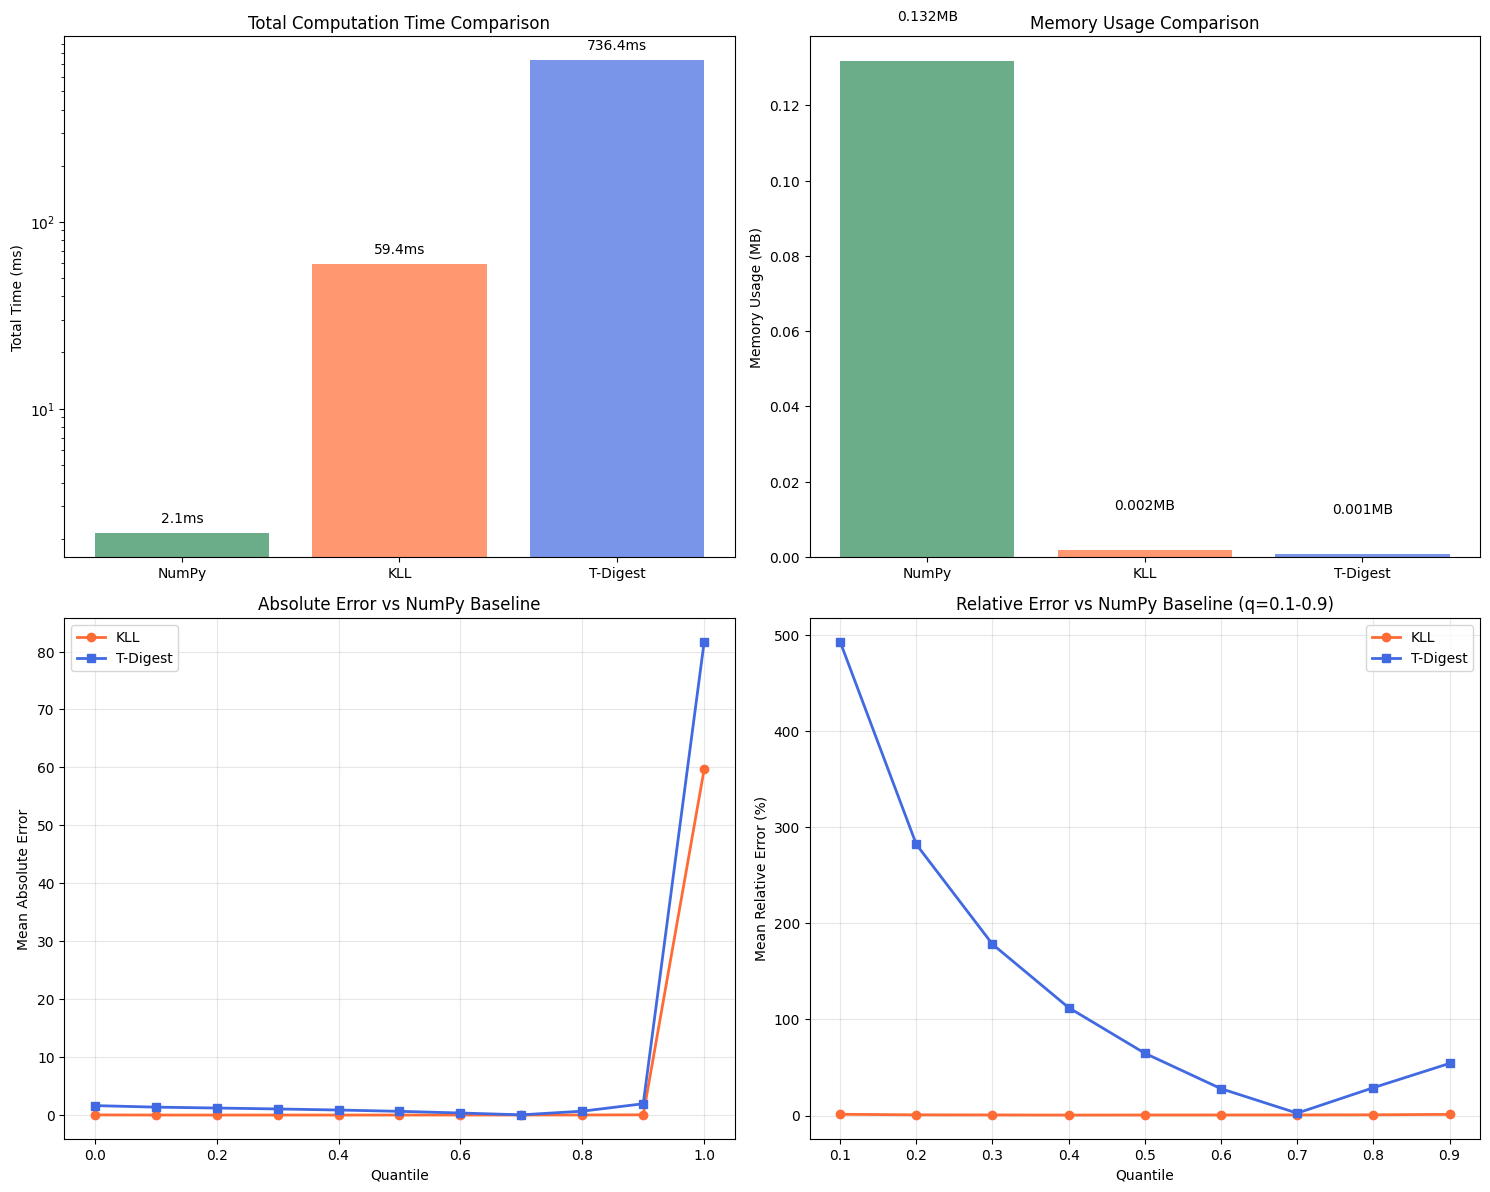

KEY INSIGHTS
- NumPy is fastest: 2.1ms (exact computation)
- KLL is 27.7x slower but enables streaming
- T-Digest is 343.1x slower but also enables streaming
- Both approximation algorithms use minimal memory
- KLL average relative error: 0.748%
- T-Digest average relative error: 138.301%


In [12]:
# Create visualization plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Total Time Comparison (log scale)
algorithms = summary_df['Algorithm']
total_times = summary_df['Total Time (ms)']
colors = ['#2E8B57', '#FF6B35', '#4169E1']

bars1 = ax1.bar(algorithms, total_times, color=colors, alpha=0.7)
ax1.set_ylabel('Total Time (ms)')
ax1.set_title('Total Computation Time Comparison')
ax1.set_yscale('log')
for i, (bar, time) in enumerate(zip(bars1, total_times)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1, 
             f'{time:.1f}ms', ha='center', va='bottom')

# 2. Memory Usage Comparison
memory_usage = summary_df['Memory Usage (MB)']
bars2 = ax2.bar(algorithms, memory_usage, color=colors, alpha=0.7)
ax2.set_ylabel('Memory Usage (MB)')
ax2.set_title('Memory Usage Comparison')
for i, (bar, mem) in enumerate(zip(bars2, memory_usage)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{mem:.3f}MB', ha='center', va='bottom')

# 3. Accuracy - Absolute Error by Quantile
ax3.plot(accuracy_df['Quantile'], accuracy_df['KLL Mean Abs Error'], 
         'o-', color='#FF6B35', label='KLL', linewidth=2, markersize=6)
ax3.plot(accuracy_df['Quantile'], accuracy_df['T-Digest Mean Abs Error'], 
         's-', color='#4169E1', label='T-Digest', linewidth=2, markersize=6)
ax3.set_xlabel('Quantile')
ax3.set_ylabel('Mean Absolute Error')
ax3.set_title('Absolute Error vs NumPy Baseline')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Accuracy - Relative Error by Quantile (excluding q=0.0 and q=1.0 for readability)
mask = (accuracy_df['Quantile'] > 0.0) & (accuracy_df['Quantile'] < 1.0)
filtered_quantiles = accuracy_df['Quantile'][mask]
kll_rel_filtered = accuracy_df['KLL Mean Rel Error (%)'][mask]
tdigest_rel_filtered = accuracy_df['T-Digest Mean Rel Error (%)'][mask]

ax4.plot(filtered_quantiles, kll_rel_filtered, 
         'o-', color='#FF6B35', label='KLL', linewidth=2, markersize=6)
ax4.plot(filtered_quantiles, tdigest_rel_filtered, 
         's-', color='#4169E1', label='T-Digest', linewidth=2, markersize=6)
ax4.set_xlabel('Quantile')
ax4.set_ylabel('Mean Relative Error (%)')
ax4.set_title('Relative Error vs NumPy Baseline (q=0.1-0.9)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print key insights
print("="*60)
print("KEY INSIGHTS")
print("="*60)
print(f"- NumPy is fastest: {total_times[0]:.1f}ms (exact computation)")
print(f"- KLL is {total_times[1]/total_times[0]:.1f}x slower but enables streaming")
print(f"- T-Digest is {total_times[2]/total_times[0]:.1f}x slower but also enables streaming")
print(f"- Both approximation algorithms use minimal memory")
print(f"- KLL average relative error: {accuracy_df['KLL Mean Rel Error (%)'][1:-1].mean():.3f}%")
print(f"- T-Digest average relative error: {accuracy_df['T-Digest Mean Rel Error (%)'][1:-1].mean():.3f}%")